###Prepare Data

I am using datasets from the following links in this notebook.<br>
**covid_19_data.csv:** https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset<br>
**countryLockdowndates.csv:** https://www.kaggle.com/jcyzag/covid19-lockdown-dates-by-country

In [0]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [0]:
df_cases = pd.read_csv('/content/drive/My Drive/Big Data/covid_19_data.csv')
df_lockdown = pd.read_csv('/content/drive/My Drive/Big Data/countryLockdowndates.csv')

df_cases['Date'] = pd.to_datetime(df_cases['ObservationDate'])
df_cases['Country/Region'] = df_cases['Country/Region'].replace('Mainland China', 'China')
df_cases['Country/Region'] = df_cases['Country/Region'].replace('UK', 'United Kingdom')
df_cases['Province/State'] = df_cases['Province/State'].replace('Taiwan', '-')
df_cases = df_cases[(df_cases['Country/Region'] != "('St. Martin',)") & (df_cases['Country/Region'] != "St. Martin")]
df_cases['Country/Region'] = df_cases['Country/Region'].str.strip()

df_lockdown['Date'] = pd.to_datetime(df_lockdown['Date'])
df_lockdown['Country/Region'] = df_lockdown['Country/Region'].replace('Korea, South', 'South Korea')
df_lockdown['Country/Region'] = df_lockdown['Country/Region'].replace('Taiwan*', 'Taiwan')
df_lockdown.loc[df_lockdown['Province'] == 'Hong Kong', 'Country/Region'] = 'Hong Kong'
df_lockdown.loc[df_lockdown['Date'] > pd.to_datetime('5/1/2020'), 'Date'] = pd.to_datetime(df_lockdown.loc[df_lockdown['Date'] > pd.to_datetime('5/1/2020'), 'Date'].astype(str), format='%Y-%d-%m')

In [0]:
df = df_cases.fillna('-').merge(df_lockdown.fillna('-'), left_on=['Country/Region', 'Province/State'],\
                    right_on=['Country/Region', 'Province'], how='left')\
                    .drop(columns=['Reference', 'Province', 'Type'])
df.loc[df['Date_y'] == '-', 'Date_y'] = pd.to_datetime('1/1/2100')

In [0]:
df['Lockdown'] = False
df.loc[(df['Date_x'] >= df['Date_y']), 'Lockdown'] = True
df = df.drop(columns=['Date_y', 'Last Update', 'SNo', 'ObservationDate'])
df = df[df['Confirmed'] > 100]

In [0]:
df[['Diff_Confirmed', 'Diff_Deaths']] = df[['Country/Region', 'Province/State', 'Confirmed', 'Deaths']].groupby(['Country/Region', 'Province/State']).diff()
df = df.fillna(0)

In [0]:
df[['Max_Confirmed', 'Max_Deaths']] = df.groupby(['Country/Region', 'Province/State'])[['Diff_Confirmed', 'Diff_Deaths']].transform(max)
temp = df[df['Diff_Confirmed'] == df['Max_Confirmed']].groupby(['Country/Region', 'Province/State']).first()['Date_x'].reset_index(name='Date_Max_Confirmed')
df = df.merge(temp, on=['Country/Region', 'Province/State'])
temp = df[df['Diff_Deaths'] == df['Max_Deaths']].groupby(['Country/Region', 'Province/State']).first()['Date_x'].reset_index(name='Date_Max_Deaths')
df = df.merge(temp, on=['Country/Region', 'Province/State'])

In [0]:
temp_df1 = df.groupby(['Country/Region', 'Province/State']).size().reset_index(name='Days')
temp_df2 = df.groupby(['Country/Region', 'Province/State']).last()[['Confirmed', 'Deaths', 'Lockdown', 'Max_Confirmed', 'Max_Deaths']]
temp_df3 = df.groupby(['Country/Region', 'Province/State']).mean()
temp_df4 = df[df['Lockdown'] == True].groupby(['Country/Region', 'Province/State']).size().reset_index(name='Lockdown_Days')
temp_df5 = df[df['Date_x'] >= pd.to_datetime('04/05/2020', format='%d/%m/%Y')].groupby(['Country/Region', 'Province/State']).mean()
temp_df6 = df[df['Date_x'] >= df['Date_Max_Confirmed']].groupby(['Country/Region', 'Province/State']).size().reset_index(name='Days_After_Max')
temp_df7 = df[(df['Date_x'] >= df['Date_Max_Confirmed'] - timedelta(days=6)) & (df['Date_x'] <= df['Date_Max_Confirmed'])]\
            .groupby(['Country/Region', 'Province/State']).mean()['Diff_Confirmed']
temp_df8 = df[(df['Date_x'] >= df['Date_Max_Deaths'] - timedelta(days=6)) & (df['Date_x'] <= df['Date_Max_Deaths'])]\
            .groupby(['Country/Region', 'Province/State']).mean()['Diff_Deaths']

In [0]:
newDF = temp_df2.merge(temp_df1, on=['Country/Region', 'Province/State'])
newDF = newDF[(newDF['Confirmed'] >= 100) & (newDF['Days'] >= 30)]
newDF = newDF.merge(temp_df3[['Diff_Confirmed', 'Diff_Deaths']], on=['Country/Region', 'Province/State'])
newDF = newDF.merge(temp_df4, on=['Country/Region', 'Province/State'], how='left')
newDF = newDF.merge(temp_df5[['Diff_Confirmed', 'Diff_Deaths']], on=['Country/Region', 'Province/State'])
newDF = newDF.merge(temp_df6, on=['Country/Region', 'Province/State'])
newDF = newDF.merge(temp_df7, on=['Country/Region', 'Province/State'])
newDF = newDF.merge(temp_df8, on=['Country/Region', 'Province/State'])
newDF = newDF.fillna(0)

In [0]:
newDF['Death_Rate'] = newDF['Deaths'] / newDF['Confirmed']

newDF.columns = ['Country', 'Province', 'Confirmed', 'Deaths', 'Lockdown',
                 'C_Max', 'D_Max', 'Days', 'Avg_C', 'Avg_D', 
                 'Lockdown_Days', 'C_LastWeek/Avg', 'D_LastWeek/Avg', 
                 'After_Max', 'C_MaxWeek', 'D_MaxWeek', 'Death_Rate']

newDF['D_LastWeek/Avg'] = newDF['D_LastWeek/Avg'] / newDF['Avg_D']
newDF['C_LastWeek/Avg'] = newDF['C_LastWeek/Avg'] / newDF['Avg_C']
newDF = newDF.fillna(0)

####Country Profile

In [10]:
newDF = newDF[['Country', 'Province', 'Confirmed', 'Deaths', 'Days', 
       'Avg_C', 'Avg_D', 'C_Max', 'D_Max', 'After_Max', 'Lockdown', 
       'Lockdown_Days', 'C_MaxWeek', 'D_MaxWeek', 'C_LastWeek/Avg', 
       'D_LastWeek/Avg', 'Death_Rate']]
newDF.head(5)

,Country,Province,Confirmed,Deaths,Days,Avg_C,Avg_D,C_Max,D_Max,After_Max,Lockdown,Lockdown_Days,C_MaxWeek,D_MaxWeek,C_LastWeek/Avg,D_LastWeek/Avg,Death_Rate
0,Afghanistan,-,4033.0,115.0,44,89.159091,2.522727,330.0,13.0,5,True,44.0,199.428571,5.000000,2.484323,1.981982,0.028515
1,Albania,-,856.0,31.0,48,15.666667,0.562500,34.0,4.0,15,True,48.0,23.428571,1.428571,0.648936,0.000000,0.036215
2,Algeria,-,5558.0,494.0,50,108.380000,9.580000,199.0,30.0,11,True,47.0,134.000000,21.285714,1.666974,0.539318,0.088881
3,Andorra,-,754.0,48.0,49,13.081633,0.959184,43.0,4.0,44,True,49.0,25.666667,1.571429,0.076443,0.521277,0.063660
4,Argentina,-,5776.0,300.0,51,110.745098,5.823529,291.0,14.0,17,True,51.0,123.428571,9.000000,1.494423,1.545455,0.051939


#### Selected Features

In [11]:
finalDF = newDF.drop(columns=['Confirmed', 'Deaths', 'Lockdown', 'Lockdown_Days', 'Avg_C', 'Avg_D', 'C_Max', 'D_Max']).groupby(['Country', 'Province']).last()
finalDF = finalDF[(finalDF['C_LastWeek/Avg'] >= 0) & (finalDF['D_LastWeek/Avg'] >= 0)]
finalDF.head(5)

,,Days,After_Max,C_MaxWeek,D_MaxWeek,C_LastWeek/Avg,D_LastWeek/Avg,Death_Rate
Country,Province,,,,,,,
Afghanistan,-,44,5,199.428571,5.000000,2.484323,1.981982,0.028515
Albania,-,48,15,23.428571,1.428571,0.648936,0.000000,0.036215
Algeria,-,50,11,134.000000,21.285714,1.666974,0.539318,0.088881
Andorra,-,49,44,25.666667,1.571429,0.076443,0.521277,0.063660
Argentina,-,51,17,123.428571,9.000000,1.494423,1.545455,0.051939


### Clustering

In [0]:
mms = MinMaxScaler()
scaled = pd.DataFrame(mms.fit_transform(finalDF),
                      columns=finalDF.columns,
                      index=finalDF.index)

#### Find the best K (n_clusters) using Silhouette method

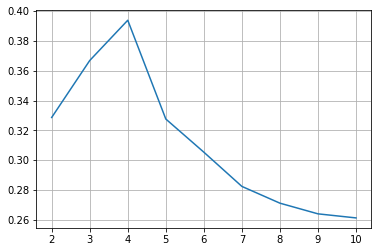

In [13]:
w = []
for k in np.arange(2, 11, 1):
  model = KMeans(n_clusters=k, n_jobs=-1).fit(scaled)
  preds = model.predict(scaled)
  silhouette = silhouette_score(scaled, preds)
  w.append(silhouette)
  
plt.plot(np.arange(2, 11, 1),w)
plt.grid()
plt.savefig('silhouettle.png')

In [0]:
n_clusters = 4

cls = KMeans(n_clusters=n_clusters, n_jobs=-1)
cls.fit(scaled)

model = KMeans(n_clusters=n_clusters).fit(scaled)
cluster = scaled.copy()
cluster['CLUSTER'] = cls.labels_

#### Clustermap

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


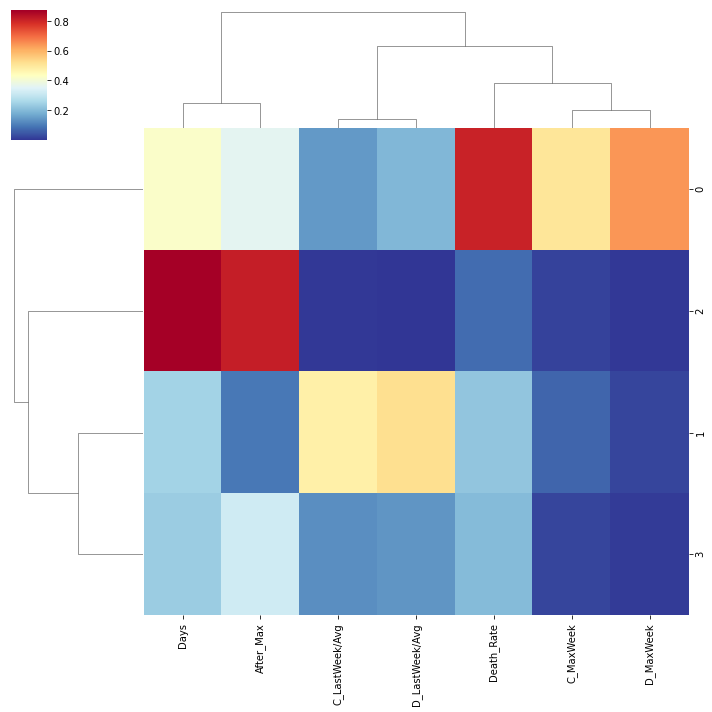

In [15]:
centroid = pd.DataFrame(model.cluster_centers_, columns=scaled.columns)
import seaborn as sns
map = sns.clustermap(centroid, cmap='RdYlBu_r')
map.savefig('clustermap.png', dpi=400)
map

### Results

In [16]:
cluster.groupby("CLUSTER").size()

CLUSTER
0    101
1     88
2     25
3      7
dtype: int64

In [17]:
temp = finalDF.merge(cluster['CLUSTER'], on=['Country', 'Province'])
temp.groupby("CLUSTER").mean()

,Days,After_Max,C_MaxWeek,D_MaxWeek,C_LastWeek/Avg,D_LastWeek/Avg,Death_Rate
CLUSTER,,,,,,,
0,48.940594,33.712871,259.440995,12.967539,0.490346,0.494650,0.033461
1,49.909091,10.602273,687.814935,29.706412,1.825537,1.846670,0.036522
2,98.920000,83.480000,197.205619,7.770857,0.022380,0.008366,0.012652
3,63.428571,37.285714,5123.265306,736.387755,0.554458,0.702337,0.132245


In [18]:
temp = newDF.merge(cluster['CLUSTER'], on=['Country', 'Province'])
temp.groupby("CLUSTER").mean()

,Confirmed,Deaths,Days,Avg_C,Avg_D,C_Max,D_Max,After_Max,Lockdown,Lockdown_Days,C_MaxWeek,D_MaxWeek,C_LastWeek/Avg,D_LastWeek/Avg,Death_Rate
CLUSTER,,,,,,,,,,,,,,,
0,9148.356436,454.910891,48.940594,153.919253,7.685941,434.603960,25.980198,33.712871,0.801980,38.178218,259.440995,12.967539,0.490346,0.494650,0.033461
1,19371.761364,806.306818,49.909091,357.095370,14.708127,1103.375000,58.465909,10.602273,0.829545,38.829545,687.814935,29.706412,1.825537,1.846670,0.036522
2,3725.640000,195.280000,98.920000,34.752420,1.817878,677.080000,53.160000,83.480000,1.000000,98.760000,197.205619,7.770857,0.022380,0.008366,0.012652
3,179994.857143,22192.285714,63.428571,2853.650727,352.257738,9634.285714,1668.857143,37.285714,1.000000,51.857143,5123.265306,736.387755,0.554458,0.702337,0.132245


#### Searching a country

temp[temp['Country'] == '*Country_name*']

In [19]:
temp[temp['Country'] == 'Thailand']

,Country,Province,Confirmed,Deaths,Days,Avg_C,Avg_D,C_Max,D_Max,After_Max,Lockdown,Lockdown_Days,C_MaxWeek,D_MaxWeek,C_LastWeek/Avg,D_LastWeek/Avg,Death_Rate,CLUSTER
152,Thailand,-,3004.0,56.0,56,51.607143,0.982143,188.0,4.0,49,True,49.0,69.285714,2.0,0.113033,0.339394,0.018642,0


<hr>